In [177]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("311-2014-2015.csv")

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (8,17,40,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
cols = ['Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Status', 'Latitude', 'Longitude']
df = df[cols]

In [36]:
nyc_facilities = pd.read_csv("NYCfac.txt",encoding = 'iso-8859-1')

In [45]:
factype = pd.read_csv("Factype.txt",encoding = 'iso-8859-1')

In [53]:
factype[factype['FT_Map'].str.contains("Fire")]

,FacType,FT_Decode,FT_Report,FT_Map
107,2101,NYC Fire House,NYC Fire House,NYC Fire House


In [ ]:
#Police station = FacType 2001
#Fire House = FacType 2101

In [59]:
pdfd = nyc_facilities[nyc_facilities['FacType'].isin([2001, 2101])]

In [64]:
pdfd_cols = ['Borough','ZipCode', 'FacType','PolicePrct','XCoord', 'YCoord']
pdfd = pdfd[pdfd_cols]

In [82]:
import pyproj

def convert(x, y):
    state_plane = pyproj.Proj(init='ESRI:102718', preserve_units=True)
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    lng, lat = pyproj.transform(state_plane, wgs, x, y)
    return lat, lng

In [84]:
pdfd.head()

,Borough,ZipCode,FacType,PolicePrct,XCoord,YCoord
258,BK,11224,2001,60,990869,149279
259,BK,11223,2001,61,995238,155733
260,BK,11214,2001,62,983394,158816
261,BK,11210,2001,63,1000448,168068
262,BK,11204,2001,66,986633,167258


In [105]:
def get_lat(row):
    x = row["XCoord"]
    y = row["YCoord"]
    lat, lon = convert(x, y)
    return lat

def get_lon(row):
    x = row["XCoord"]
    y = row["YCoord"]
    lat, lon = convert(x, y)
    return lon

In [98]:
pdfd["Latitude"] = pdfd.apply(get_lat, axis=1)
pdfd["Longitude"] = pdfd.apply(get_lon, axis=1)

In [109]:
#Police station = FacType 2001
#Fire House = FacType 2101
pdfd['Type'] = pdfd['FacType'].apply(lambda x: "Police" if x == 2001 else "Fire")

In [112]:
pdfd.head()

,Borough,ZipCode,FacType,PolicePrct,XCoord,YCoord,Latitude,Longitude,Type
258,BK,11224,2001,60,990869,149279,40.576410,-73.976173,Police
259,BK,11223,2001,61,995238,155733,40.594120,-73.960435,Police
260,BK,11214,2001,62,983394,158816,40.602589,-74.003083,Police
261,BK,11210,2001,63,1000448,168068,40.627970,-73.941646,Police
262,BK,11204,2001,66,986633,167258,40.625761,-73.991415,Police


In [113]:
pdfd.to_csv("nypd-nyfd-stations.csv", index=False)

In [119]:
df = df[df["Agency"] == "NYPD"]

In [121]:
df.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Status,Latitude,Longitude
0,2016-04-14 02:10:19,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,11436,Open,40.684998,-73.795037
1,2016-04-14 02:10:07,04/14/2016 03:17:04 AM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11221,Closed,40.695371,-73.928720
3,2016-04-14 02:08:10,04/14/2016 03:17:08 AM,NYPD,New York City Police Department,Animal Abuse,Neglected,Residential Building/House,11221,Closed,40.695371,-73.928720
4,2016-04-14 02:07:42,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,10003,Open,40.730038,-73.992632
6,2016-04-14 02:00:05,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11223,Assigned,40.601353,-73.981346


In [132]:
df["Closed Date"] = pd.to_datetime(df["Closed Date"], infer_datetime_format=True)

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [163]:
df["Response Time Minutes"] = (df["Closed Date"] - df["Created Date"]) / np.timedelta64(1, 'm')

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [322]:
df2 = df[df['Response Time Minutes'] > 0]

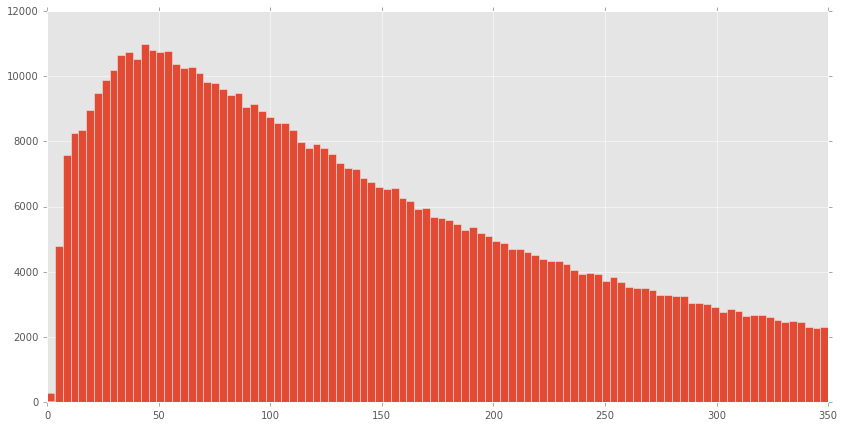

In [323]:
df2['Response Time Minutes'].hist(range=(0, 350), bins=100, figsize=(14, 7))

In [324]:
df2['Response Time Minutes'].median()

149.15833333333333

In [200]:
nypd = pdfd[pdfd["Type"] == "Police"]

In [201]:
from geopy.distance import vincenty

In [210]:
nypd.head()

,Borough,ZipCode,FacType,PolicePrct,XCoord,YCoord,Latitude,Longitude,Type
0,BK,11224,2001,60,990869,149279,40.576410,-73.976173,Police
1,BK,11223,2001,61,995238,155733,40.594120,-73.960435,Police
2,BK,11214,2001,62,983394,158816,40.602589,-74.003083,Police
3,BK,11210,2001,63,1000448,168068,40.627970,-73.941646,Police
4,BK,11204,2001,66,986633,167258,40.625761,-73.991415,Police


In [302]:
from scipy import spatial
x, y = nypd.Latitude.values, nypd.Longitude.values
tree = spatial.KDTree(list(zip(x.ravel(), y.ravel())))
tree.data

array([[ 40.57640987, -73.97617306],
       [ 40.59412047, -73.96043514],
       [ 40.60258945, -74.00308262],
       [ 40.62796951, -73.94164573],
       [ 40.62576072, -73.99141538],
       [ 40.64864184, -73.95033414],
       [ 40.63899422, -74.02246207],
       [ 40.64838546, -73.90494258],
       [ 40.6303583 , -73.97371118],
       [ 40.66451651, -73.94774507],
       [ 40.65818519, -74.0010308 ],
       [ 40.68387081, -74.0003245 ],
       [ 40.68057147, -73.97431512],
       [ 40.67063309, -73.91338592],
       [ 40.67109042, -73.88142796],
       [ 40.67457506, -73.93022012],
       [ 40.6888639 , -73.9445276 ],
       [ 40.68960176, -73.92439891],
       [ 40.6978921 , -73.91803514],
       [ 40.69546069, -73.98282364],
       [ 40.69007272, -73.9605585 ],
       [ 40.7062192 , -73.95086832],
       [ 40.72687436, -73.95286992],
       [ 40.81038774, -73.92530932],
       [ 40.81638357, -73.895295  ],
       [ 40.82254788, -73.91126963],
       [ 40.8231507 , -73.86972868],
 

In [295]:
def closest_station(row):
    lat = row["Latitude"]
    lon = row["Longitude"]
    incident = (lat, lon)
    distances = []
    for i in range(len(nypd)):
        station = (nypd.ix[i].Latitude, nypd.ix[i].Longitude)
        distances.append(vincenty(incident, station).kilometers)
    #frame = nypd.ix[np.argmin(distances)][["Borough", "ZipCode", "PolicePrct"]]
    #frame["Distance Km"] = min(distances)
    #return frame
    return np.argmin(distances)

In [315]:
def closest_tree_station(row):
    lat = row["Latitude"]
    lon = row["Longitude"]
    incident = (lat, lon)
    index = tree.query(incident)[1]
    station = (nypd.ix[index].Latitude, nypd.ix[index].Longitude)
    frame = nypd.ix[index][["Borough", "ZipCode", "PolicePrct"]]
    frame["Distance Km"] = vincenty(incident, station).kilometers
    return frame

In [325]:
df2 = df2.dropna()

In [273]:
import pygeohash as pgh

In [277]:
def geohash(row):
    lat = row['Latitude']
    lon = row['Longitude']
    ghash = pgh.encode(lat, lon, precision=7)
    return ghash

In [281]:
df2['geohash'] = df2.apply(geohash, axis=1)

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [283]:
nypd['geohash'] = nypd.apply(geohash, axis=1)

In [285]:
def approximate_closest(row):
    ghash = row["geohash"]
    incident = (lat, lon)
    distances = []
    for i in range(len(nypd)):
        station = nypd.ix[i].geohash
        distances.append(pgh.geohash_approximate_distance(ghash, station))
    frame = nypd.ix[np.argmin(distances)][["Borough", "ZipCode", "PolicePrct"]]
    frame["Distance Km"] = min(distances)
    return frame

In [320]:
df2.head(10).apply(closest_tree_station, axis=1)

,Borough,ZipCode,PolicePrct,Distance Km
1,BK,11221,81,0.737484
3,BK,11221,81,0.737484
15,BK,11237,83,1.090962
16,MN,10013,1,0.479000
19,MN,10003,9,0.342959
20,QN,11365,107,1.912257
21,MN,10002,7,0.407213
22,MN,10001,14,0.430607
23,QN,11385,104,1.297239
24,MN,10025,24,0.687576


In [326]:
df2 = pd.concat([df2, df2.apply(closest_tree_station, axis=1)], axis=1)

In [328]:
df2.to_csv("df.csv", index=False)